In [78]:
import pathlib
import requests

import joblib
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from sklearn import base, compose, dummy, linear_model, model_selection
from sklearn import metrics, multioutput, pipeline, preprocessing, utils

# MNIST Dataset

The original [MNIST](http://yann.lecun.com/exdb/mnist/) dataset consists of 70000 28x28 black and white images in 10 classes. There are 60000 training images and 10000 test images.

In [2]:
# might be different if using Colab or Kaggle
PROJECT_ROOT_DIR = pathlib.Path(".")

DATA_DIR = PROJECT_ROOT_DIR / "data" / "mnist"
DATA_DIR.mkdir(parents=True, exist_ok=True)

RESULTS_DIR = PROJECT_ROOT_DIR / "results" / "mnist"
RESULTS_DIR.mkdir(parents=True, exist_ok=True)


### Download and extract the data (if using Colab or Kaggle!)

In [3]:
URL = "https://github.com/davidrpugh/machine-learning-for-tabular-data/blob/main/data/mnist/mnist.parquet?raw=true"

with open(DATA_DIR / "mnist.parquet", 'wb') as f:
    response = requests.get(URL)
    f.write(response.content)


In [4]:
%%bash
ls -lh ./data/mnist

total 21M
-rw-r--r-- 1 root root 21M Nov 27 06:29 mnist.parquet


## Load the data

We will load the data using the [Pandas](https://pandas.pydata.org/) library. Highly recommend the most recent edition of [*Python for Data Analysis*](https://learning.oreilly.com/library/view/python-for-data/9781491957653/) by Pandas creator Wes Mckinney for anyone interested in learning how to use Pandas.

In [5]:
data = pd.read_parquet(DATA_DIR / "mnist.parquet")
features = data.drop("label", axis=1)
target = data.loc[:, "label"]

## Explore the data

In [6]:
features.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 70000 entries, 0 to 69999
Columns: 784 entries, pixel1 to pixel784
dtypes: uint8(784)
memory usage: 52.3 MB


In [7]:
features.head()

,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,pixel9,pixel10,...,pixel775,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783,pixel784
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [8]:
features.tail()

,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,pixel9,pixel10,...,pixel775,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783,pixel784
69995,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
69996,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
69997,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
69998,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
69999,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [9]:
features.describe()

,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,pixel9,pixel10,...,pixel775,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783,pixel784
count,70000.0,70000.0,70000.0,70000.0,70000.0,70000.0,70000.0,70000.0,70000.0,70000.0,...,70000.000000,70000.000000,70000.000000,70000.000000,70000.000000,70000.000000,70000.0,70000.0,70000.0,70000.0
mean,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.197414,0.099543,0.046629,0.016614,0.012957,0.001714,0.0,0.0,0.0,0.0
std,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,5.991206,4.256304,2.783732,1.561822,1.553796,0.320889,0.0,0.0,0.0,0.0
min,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0
25%,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0
50%,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0
75%,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0
max,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,254.000000,254.000000,253.000000,253.000000,254.000000,62.000000,0.0,0.0,0.0,0.0


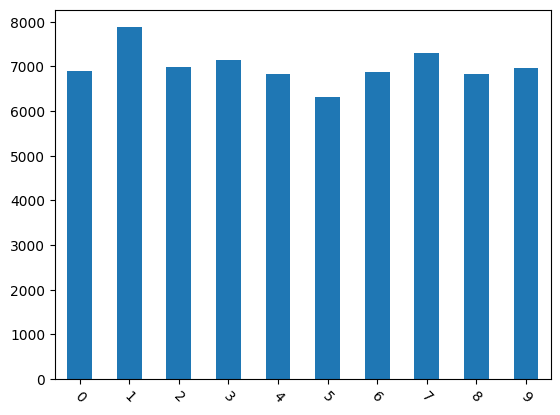

In [10]:
_ = (target.value_counts()
           .sort_index()
           .plot(kind="bar"))
_ = plt.xticks(rotation=-45)

## Visualize the data

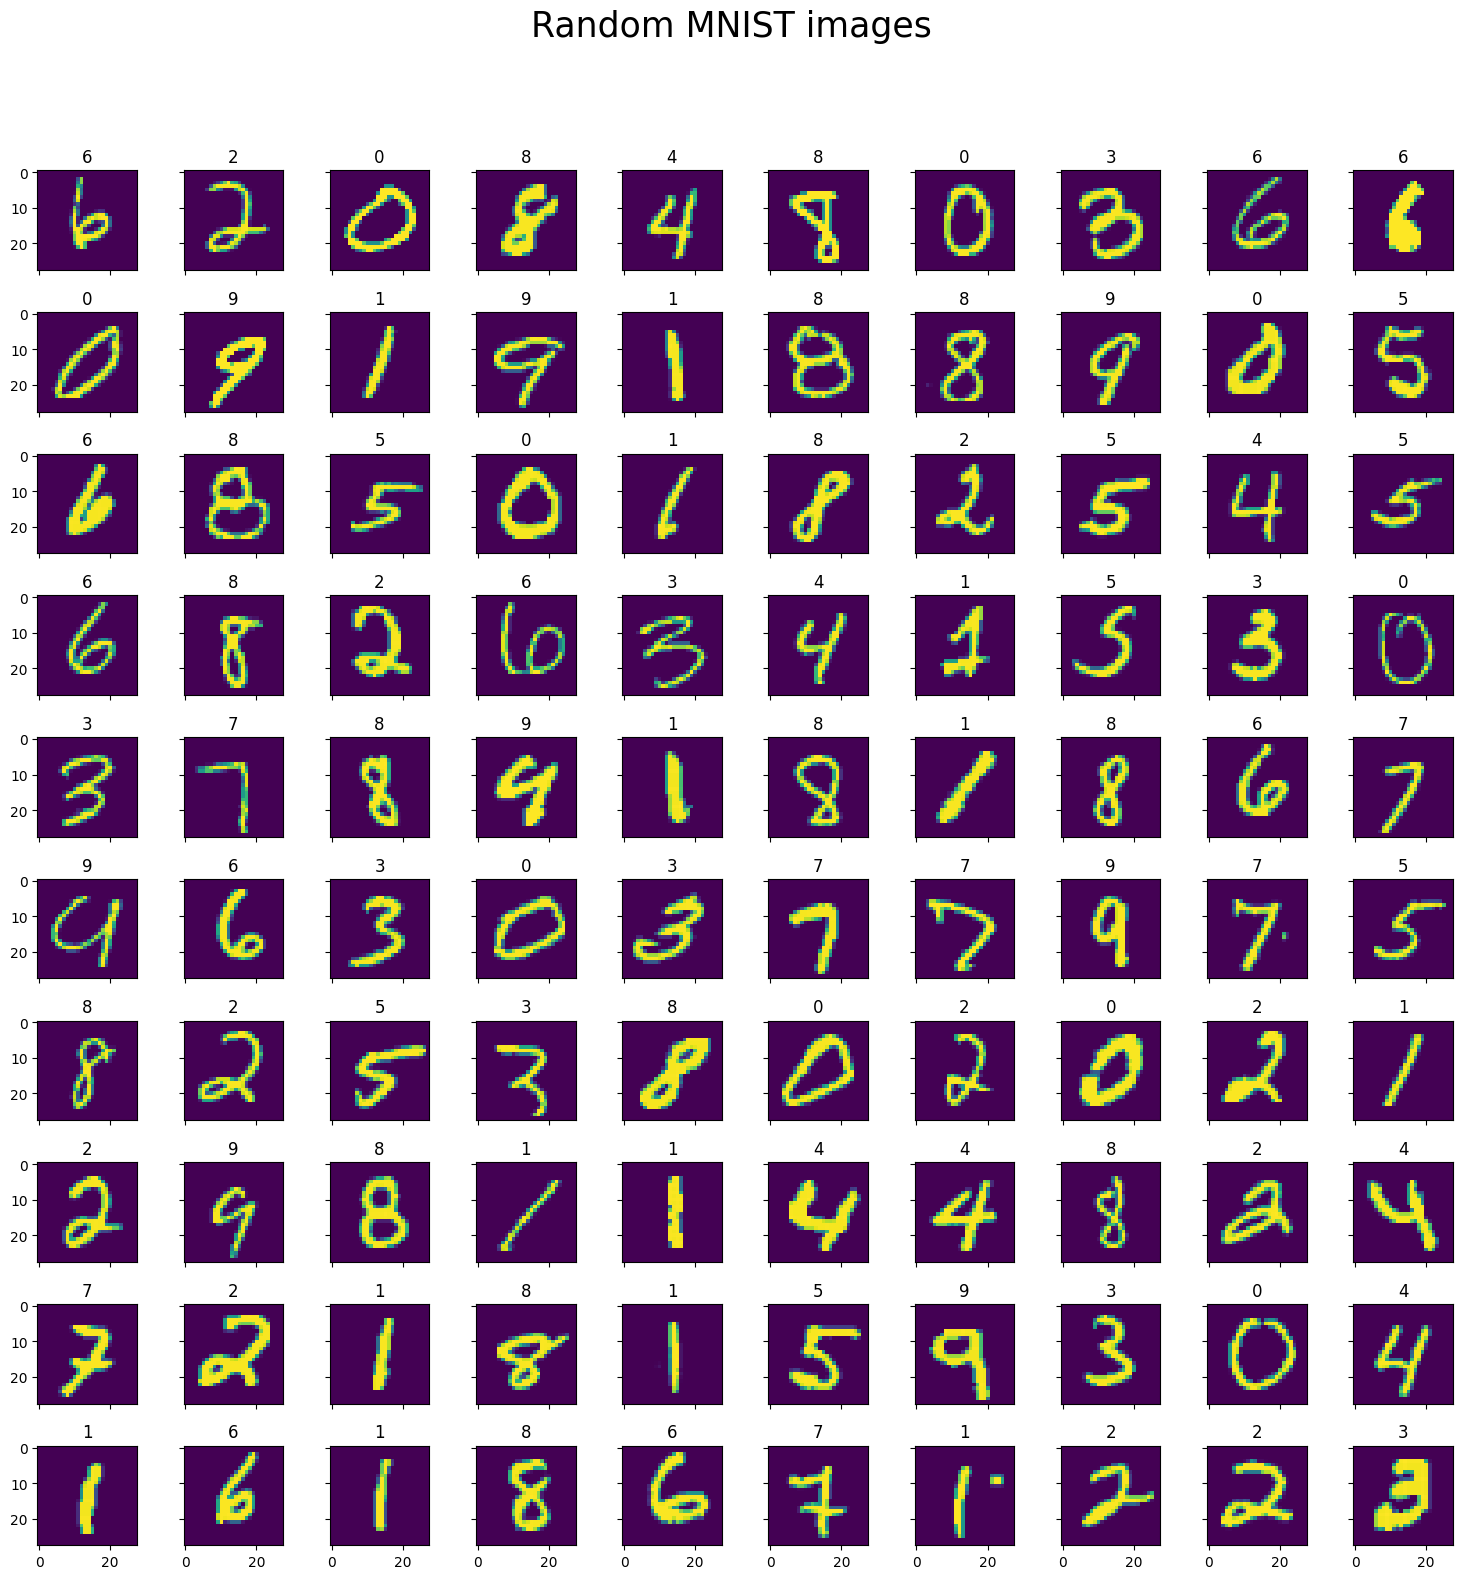

In [11]:
fig, axes = plt.subplots(10, 10, sharex=True, sharey=True, figsize=(15, 15))
for i in range(10):
    for j in range(10):
        m, _ = features.shape
        k = np.random.randint(m)
        img = (features.loc[k, :]
                       .to_numpy()
                       .reshape((28, 28)))
        _ = axes[i, j].imshow(img)
        _ = axes[i, j].set_title(target.iloc[k])

fig.suptitle("Random MNIST images", x=0.5, y=1.05, fontsize=25)
fig.tight_layout()

# Look at the Big Picture

## Framing the problem

### What is the business/research objective?

Typically building the model is not the overall objective but rather the model itself is one part of a larger process used to answer a business/research question. Knowing the overall objective is important because it will determine your choice of machine learning algorithms to train, your measure(s) of model performance, and how much time you will spend tweaking the hyper-parameters of your model.

In our example today, the overall business/research objective is to build a tool for reading electricity meter serial numbers which consist of sequences of sometimes handwritten digits. Part of this tool will be a model that can correctly classify individual handwritten digits. Our image classication model is just one of potentially many other models whose predictions are taken as inputs into another machine learning model that will be used to read off the electricity meter serial numbers.

### What is the current solution?

Always a good idea to know what the current solution to the problem you are trying to solve. Current solution gives a benchmark for performance. Note that the current "best" solution could be very simple or could be very sophisticated. Understanding the current solution helps you think of a good place to start. Example: suppose that the current solution for predicting the price of a house in a given census block is to ignore all the demographic information and predict a simple average of house prices in nearby census blocks. In this case it would probably not make sense to start building a complicated deep learning model to predict housing prices. However, if the current solution was a tuned gradient boosted machine then it probably would not make sense to try a much simpler linear regression model.

With all this information, you are now ready to start designing your system. First, you need to frame the problem by answering the following questions.

* Is our problem supervised, unsupervised, or reinforcement learning?
* Is our problem a classification task, a regression task, or something else? If our problem is a classification task are we trying to classify samples into 2 categories (binary classification) or more than 2 (multi-class classification) categories? If our problem is a regression task, are we trying to predict a single value (univariate regression) or multiple values (multivariate regression) for each sample?
* Should you use batch learning or online learning techniques?


### Exercise: Selecting a metric

Scikit-Learn has a number of different [possible metrics](https://scikit-learn.org/stable/modules/model_evaluation.html) that you can choose from (or you can create your own custom metric if required). Can you find a few metrics that seems appropriate for our image classification model?

# Creating a Test Dataset

Before we look at the data any further, we need to create a test set, put it aside, and never look at it (until we are ready to test our trainined machine learning model!). Why? We don't want our machine learning model to memorize our dataset (this is called overfitting). Instead we want a model that will generalize well (i.e., make good predictions) for inputs that it didn't see during training. To do this we hold split our dataset into training and testing datasets. The training dataset will be used to train our machine learning model(s) and the testing dataset will be used to make a final evaluation of our machine learning model(s).


## If this is all the data you will ever have...

...then you can just set a seed for the random number generator and then randomly split the data. Scikit-Learn has a [`model_selection`](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.train_test_split.html) module that contains tools for splitting datasets into training and testing sets.

In [ ]:
model_selection.train_test_split?

In [12]:
SEED = 42
SEED_GENERATOR = np.random.RandomState(SEED)


def generate_seed():
    return SEED_GENERATOR.randint(np.iinfo("uint16").max)

In [13]:
TEST_SIZE = 1e-1

# split the dataset into training and testing data
_seed = generate_seed()
_random_state = np.random.RandomState(_seed)
train_features, test_features, train_target, test_target = model_selection.train_test_split(
    features,
    target,
    test_size=TEST_SIZE,
    stratify=target,
    random_state=_random_state
)

In [14]:
train_features.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 63000 entries, 29990 to 43298
Columns: 784 entries, pixel1 to pixel784
dtypes: uint8(784)
memory usage: 47.6 MB


In [15]:
train_features.head()

,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,pixel9,pixel10,...,pixel775,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783,pixel784
29990,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
67438,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
22891,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
55259,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
18172,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [16]:
train_target.head()

29990    2
67438    6
22891    7
55259    0
18172    5
Name: label, dtype: uint8

In [17]:
train_features.describe()

,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,pixel9,pixel10,...,pixel775,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783,pixel784
count,63000.0,63000.0,63000.0,63000.0,63000.0,63000.0,63000.0,63000.0,63000.0,63000.0,...,63000.000000,63000.000000,63000.000000,63000.000000,63000.000000,63000.000000,63000.0,63000.0,63000.0,63000.0
mean,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.199524,0.104095,0.051111,0.017778,0.010524,0.000921,0.0,0.0,0.0,0.0
std,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,6.005698,4.401675,2.929272,1.637365,1.318174,0.231078,0.0,0.0,0.0,0.0
min,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0
25%,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0
50%,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0
75%,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0
max,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,254.000000,254.000000,253.000000,253.000000,254.000000,58.000000,0.0,0.0,0.0,0.0


Again, if you want to you can write out the train and test sets to disk to avoid having to recreate them later.

In [18]:
_ = (train_features.join(train_target)
                   .to_parquet(DATA_DIR / "train.parquet", index=False))

_ = (test_features.join(test_target)
                   .to_parquet(DATA_DIR / "test.parquet", index=False))

## Training a Binary Classifier

In [41]:
estimator = linear_model.LogisticRegression()
_ = estimator.fit(train_features, train_target == 5)

/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


In [42]:
estimator.predict(train_features)

array([False, False, False, ..., False, False, False])

In [43]:
train_target == 5

29990    False
67438    False
22891    False
55259    False
18172     True
         ...  
25693    False
3033     False
18713    False
42417    False
43298    False
Name: label, Length: 63000, dtype: bool

In [44]:
train_target.iloc[0]

2

In [45]:
train_target.iloc[4]

5

Congrats! You have fit your first machine learning model using Scikit-Learn and made some predictions. Now let's see how good those predictions really are.

## Performance measures

### Measuring accuracy using Cross Validation

In [46]:
CV_FOLDS = 3

estimator = linear_model.LogisticRegression()

estimator_scores = model_selection.cross_val_score(
    estimator,
    X=train_features,
    y=(train_target == 5),
    cv=CV_FOLDS,
    scoring="accuracy",
    n_jobs=-1,
    verbose=1
)

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:   41.4s finished


In [47]:
estimator_scores

array([0.97428571, 0.97414286, 0.97352381])

In [48]:
estimator_scores.mean()

0.973984126984127

In [49]:
# make predictions
_cv_predictions = model_selection.cross_val_predict(
    estimator,
    X=train_features,
    y=(train_target == 5),
    cv=CV_FOLDS,
    n_jobs=-1,
    verbose=1
)

# report the accuracy on the cv data
cv_accuracy = metrics.accuracy_score(
    (train_target == 5),
    _cv_predictions,
)
print(cv_accuracy)

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.


0.973984126984127


[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:   21.4s finished


Cross-validated accurracy score is quite high! But is our model really that good? What is the relevant benchmark?

In [50]:
_estimator = dummy.DummyClassifier(strategy="most_frequent")

_estimator_scores = model_selection.cross_val_score(
    _estimator,
    X=train_features,
    y=(train_target == 5),
    cv=CV_FOLDS,
    scoring="accuracy",
    n_jobs=-1,
    verbose=1
)

print(_estimator_scores.mean())

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.


0.9098095238095238


[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:    1.0s finished


Simply guessing "not 5" will be correct 90% of the time! Why? This example demonstrates why accuracy is not a great metric to use when you have imbalanced datasets.

### Confusion matrix

In [51]:
estimator = linear_model.LogisticRegression()

cv_predictions = model_selection.cross_val_predict(
    estimator,
    X=train_features,
    y=(train_target == 5),
    cv=CV_FOLDS,
    n_jobs=-1,
    verbose=1
)

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:   21.2s finished


In [ ]:
metrics.confusion_matrix?

In [52]:
confusion_matrix = metrics.confusion_matrix(
    (train_target == 5),
    cv_predictions,
    normalize=None
)
print(confusion_matrix)

[[56761   557]
 [ 1082  4600]]


### Precision

In [53]:
metrics.precision_score(
    (train_target == 5),
    cv_predictions,
)

0.8919914679076982

### Recall

In [54]:
metrics.recall_score(
    (train_target == 5),
    cv_predictions,
)

0.8095740936290039

### $F_1$ Score

In [55]:
metrics.f1_score(
    (train_target == 5),
    cv_predictions,
)

0.848786788449119

### Classification report

In [107]:
_report = metrics.classification_report(
    (train_target == 5),
    cv_predictions,
)
print(_report)

              precision    recall  f1-score   support

           0       0.97      0.97      0.97      6213
           1       0.96      0.98      0.97      7089
           2       0.93      0.91      0.92      6291
           3       0.92      0.91      0.91      6427
           4       0.93      0.94      0.94      6142
           5       0.90      0.89      0.90      5682
           6       0.95      0.96      0.95      6188
           7       0.95      0.94      0.94      6564
           8       0.90      0.90      0.90      6142
           9       0.90      0.92      0.91      6262

    accuracy                           0.93     63000
   macro avg       0.93      0.93      0.93     63000
weighted avg       0.93      0.93      0.93     63000



### Receiver Operating Characteristic (ROC) Area Under the Curve (AUC) Score

In [59]:
estimator = linear_model.LogisticRegression()
_ = estimator.fit(train_features, (train_target == 5))

_scores = estimator.predict_proba(train_features)
metrics.roc_auc_score(
    (train_target == 5),
    _scores[:, 1],
)

/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


0.9786759723650462

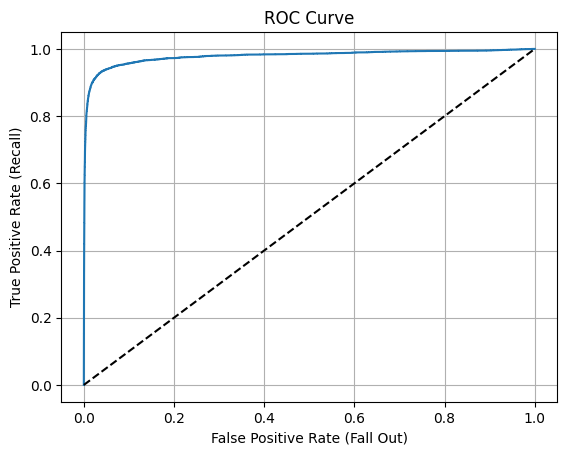

In [65]:
false_positive_rate, true_positive_rate, thresholds = metrics.roc_curve(
    (train_target == 5),
    _scores[:, 1]
)

plt.plot(false_positive_rate, true_positive_rate, label="Logistic Regression")
plt.plot(false_positive_rate, false_positive_rate, "k--", label="Random Classifier")
plt.xlabel("False Positive Rate (Fall Out)")
plt.ylabel("True Positive Rate (Recall)")
plt.title("ROC Curve")
plt.grid()

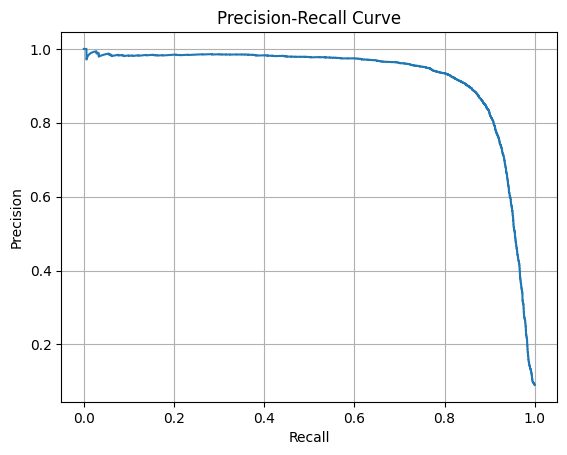

In [66]:
precisions, recalls, thresholds = metrics.precision_recall_curve(
    (train_target == 5),
    _scores[:, 1]
)

plt.plot(recalls, precisions, label="Logistic Regression")
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.title("Precision-Recall Curve")
plt.grid()

Since the ROC curve is so similar to the precision/recall (PR) curve, you may wonder how to decide which one to use.

1. Prefer the PR curve whenever the positive class is rare or when you care more about the false positives than the false negatives.
2. Otherwise, use the ROC curve.


## Multiclass Classification

Logistic Regression supports multiclass classification "out-of-the-box".

In [67]:
estimator = linear_model.LogisticRegression()
_ = estimator.fit(train_features, train_target)

/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


In [68]:
cv_predictions = model_selection.cross_val_predict(
    estimator,
    X=train_features,
    y=train_target,
    cv=CV_FOLDS,
    n_jobs=-1,
    verbose=1
)

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:  1.2min finished


## Error Analysis

In [ ]:
cv_predictions = model_selection.cross_val_predict(
    estimator,
    X=train_features,
    y=train_target,
    cv=CV_FOLDS,
    n_jobs=-1,
    verbose=1
)

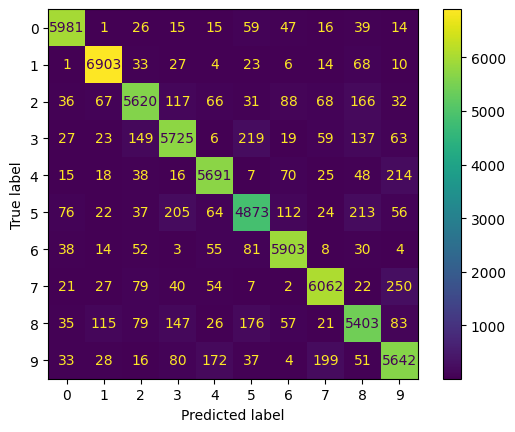

In [69]:
_ = (
    metrics.ConfusionMatrixDisplay
           .from_predictions(
                train_target,
                cv_predictions
            )
)

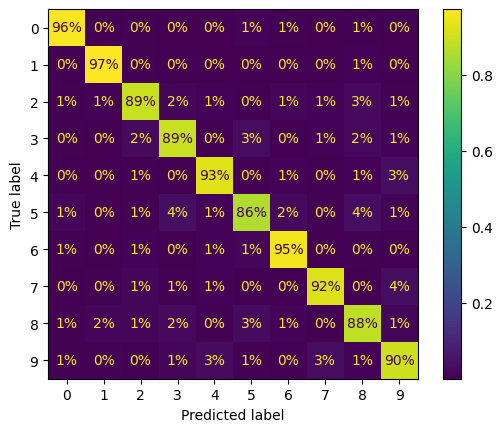

In [71]:
_ = (
    metrics.ConfusionMatrixDisplay
           .from_predictions(
                train_target,
                cv_predictions,
                normalize="true",
                values_format=".0%"
            )
)

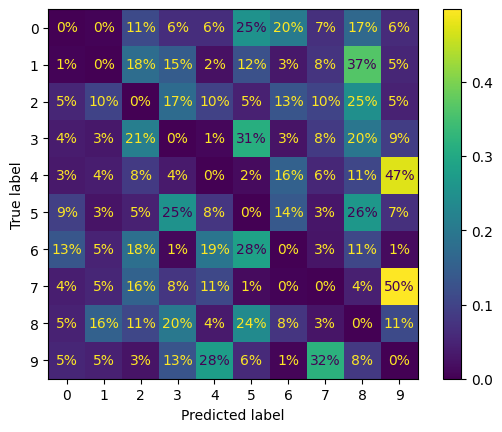

In [73]:
_ = (
    metrics.ConfusionMatrixDisplay
           .from_predictions(
                train_target,
                cv_predictions,
                normalize="true",
                sample_weight=(train_target != cv_predictions),
                values_format=".0%"
            )
)

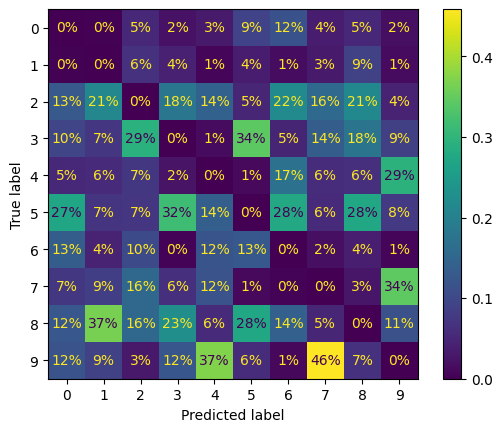

In [74]:
_ = (
    metrics.ConfusionMatrixDisplay
           .from_predictions(
                train_target,
                cv_predictions,
                normalize="pred",
                sample_weight=(train_target != cv_predictions),
                values_format=".0%"
            )
)

In [75]:
_report = metrics.classification_report(
    train_target,
    cv_predictions,
)
print(_report)

              precision    recall  f1-score   support

           0       0.95      0.96      0.96      6213
           1       0.96      0.97      0.96      7089
           2       0.92      0.89      0.90      6291
           3       0.90      0.89      0.89      6427
           4       0.92      0.93      0.93      6142
           5       0.88      0.86      0.87      5682
           6       0.94      0.95      0.94      6188
           7       0.93      0.92      0.93      6564
           8       0.87      0.88      0.88      6142
           9       0.89      0.90      0.89      6262

    accuracy                           0.92     63000
   macro avg       0.92      0.92      0.92     63000
weighted avg       0.92      0.92      0.92     63000



## Multilabel Classification

In [77]:
linear_model.LogisticRegression?

In [79]:
_multilabel_target = np.c_[train_target >= 7, train_target % 2 == 1]

_estimator = linear_model.LogisticRegression()
estimator = multioutput.ClassifierChain(
    _estimator,
    cv=CV_FOLDS,
)
_ = estimator.fit(train_features, _multilabel_target)

/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _c

In [80]:
estimator.predict(train_features)

array([[0., 0.],
       [0., 0.],
       [1., 1.],
       ...,
       [0., 0.],
       [0., 0.],
       [0., 1.]])

## Multioutput Classification

# Prepare the data for machine learning algorithms

Best practice is to write functions to automate the process of preparing your data for machine learning. Why?

* Allows you to reproduce these transformations easily on any dataset.
* You will gradually build a library of transformation functions that you can reuse in future projects.
* You can use these functions in a live system to transform the new data before feeding it to your algorithms.
* This will make it possible for you to easily experiment with various transformations and see which combination of transformations works best.

We are working with an benchmark dataset that has already been prepared for analysis (mostly!). You should be aware that academic benchmark datasets are not very representative of the type of datasets that you will encounter in most practical applications.

## Feature Scaling

Machine learning algorithms typically don’t perform well when the input numerical attributes have very different scales. The simplest approach is to rescale features so that they all reside within the same range (typically between 0 and 1). This approach is implemented in Scikit-Learn by the [`preprocessing.MinMaxScaler`](https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.MinMaxScaler.html#sklearn.preprocessing.MinMaxScaler) class.

In [ ]:
preprocessing.MinMaxScaler?

In [81]:
# hyper-parameters
_preprocessing_hyperparameters = {
    "feature_range": (-1, 1),
    "copy": True,
    "clip": False,
}

preprocessor = preprocessing.MinMaxScaler(**_preprocessing_hyperparameters)

In [82]:
preprocessed_train_features = preprocessor.fit_transform(train_features)

In [83]:
preprocessed_train_features.shape

(63000, 784)

In [23]:
preprocessed_train_features[:, :5]

array([[0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0.],
       ...,
       [0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0.]])

In [84]:
# hyper-parameters
_preprocessing_hyperparameters = {
    "feature_range": (-1, 1),
    "copy": True,
    "clip": False,
}

preprocessor = (
    preprocessing.MinMaxScaler(**_preprocessing_hyperparameters)
                 .set_output(transform="pandas")
)

In [85]:
preprocessed_train_features = preprocessor.fit_transform(train_features)

In [86]:
preprocessed_train_features.describe()

,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,pixel9,pixel10,...,pixel775,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783,pixel784
count,63000.0,63000.0,63000.0,63000.0,63000.0,63000.0,63000.0,63000.0,63000.0,63000.0,...,63000.000000,63000.000000,63000.000000,63000.000000,63000.000000,63000.000000,63000.0,63000.0,63000.0,63000.0
mean,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,...,-0.998429,-0.999180,-0.999596,-0.999859,-0.999917,-0.999968,-1.0,-1.0,-1.0,-1.0
std,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.047289,0.034659,0.023156,0.012944,0.010379,0.007968,0.0,0.0,0.0,0.0
min,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,...,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.0,-1.0,-1.0,-1.0
25%,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,...,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.0,-1.0,-1.0,-1.0
50%,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,...,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.0,-1.0,-1.0,-1.0
75%,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,...,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.0,-1.0,-1.0,-1.0
max,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,-1.0,-1.0,-1.0,-1.0


The `preprocessing.MinMaxScaler` and the `preprocessing.StandardScaler` classes are the first Scikit-Learn `Transformer` classes that we have encountered. As such now is a good to to discuss the Scikit-Learn application programming interface (API). The [Scikit-Learn API](https://scikit-learn.org/stable/modules/classes.html) is one of the best designed API's around and has heavily influenced API design choices of other libraries in the Python Data Science and Machine Learning ecosystem, in particular [Dask](https://dask.org/) and [NVIDIA RAPIDS](https://rapids.ai/). Familiarly with the Scikit-Learn API will make it easier for you to get started with these libraries.

The Scikit-Learn API is built around the following key concepts.

* Estimators: Any object that can estimate some parameters based on a dataset is called an estimator (e.g., an `preprocessing.MinMaxScaler` is an estimator). The estimation itself is performed by the `fit` method, and it takes only a dataset as a parameter (or two for supervised learning algorithms; the second dataset contains the labels). Any other parameter needed to guide the estimation process is considered a hyperparameter (such as the `feature_range` parameter in `preprocessing.MinMaxScaler`), and it must be set as an instance variable (generally via a constructor parameter).

* Transformers: Some estimators (such as an `preprocessing.MinMaxScaler`) can also transform a dataset; these are called transformers. Once again, the API is simple: the transformation is performed by the transform method with the dataset to transform as a parameter. It returns the transformed dataset. This transformation generally relies on the learned parameters. All transformers also have a convenience method called `fit_transform` that is equivalent to calling `fit` and then `transform` (but sometimes `fit_transform` is optimized and runs much faster).

* Predictors: Finally, some estimators, given a dataset, are capable of making predictions; they are called predictors. A predictor has a `predict` method that takes a dataset of new instances and returns a dataset of corresponding predictions. It also has a score method that measures the quality of the predictions, given a test set (and the corresponding labels, in the case of supervised learning algorithms).

All of an estimator’s hyperparameters are accessible directly via public instance variables (e.g., `preprocessor.feature_range`), and all the estimator’s learned parameters are accessible via public instance variables with an underscore suffix (e.g., `preprocessor.scale_`). Finally, Scikit-Learn provides reasonable default values for most parameters which makes it easy to quickly create a baseline working system.

### Exercise: MinMaxScaler vs StandardScaler

An alternative approach is to rescale features so that they all have zero mean and unit standard deviation. This approach, which is also called standardization, is particularly useful when attributes/features have outliers and when downstream machine learning algorithms assume that attributes/features have a Gaussian or Normal distribution.

Create an instance of the [`preprocessing.StandardScaler`](https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.StandardScaler.html) class and use it to rescale the training dataset. Compare the two different rescaled versions of the dataset. Which of the two methods do you prefer?

In [87]:
_hyperparameters = {
    "copy": True,
    "with_mean": True,
    "with_std": True
}
preprocessor = (
    preprocessing.StandardScaler(**_hyperparameters)
                 .set_output(transform="pandas")
)

In [88]:
preprocessed_train_features = preprocessor.fit_transform(train_features)

In [89]:
preprocessed_train_features.describe()

,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,pixel9,pixel10,...,pixel775,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783,pixel784
count,63000.0,63000.0,63000.0,63000.0,63000.0,63000.0,63000.0,63000.0,63000.0,63000.0,...,6.300000e+04,6.300000e+04,6.300000e+04,6.300000e+04,6.300000e+04,6.300000e+04,63000.0,63000.0,63000.0,63000.0
mean,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,-1.500035e-17,-1.364693e-17,-7.782135e-18,4.511382e-18,-3.496321e-18,2.255691e-18,0.0,0.0,0.0,0.0
std,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,1.000008e+00,1.000008e+00,1.000008e+00,1.000008e+00,1.000008e+00,1.000008e+00,0.0,0.0,0.0,0.0
min,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,-3.322268e-02,-2.364919e-02,-1.744854e-02,-1.085764e-02,-7.983689e-03,-3.984127e-03,0.0,0.0,0.0,0.0
25%,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,-3.322268e-02,-2.364919e-02,-1.744854e-02,-1.085764e-02,-7.983689e-03,-3.984127e-03,0.0,0.0,0.0,0.0
50%,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,-3.322268e-02,-2.364919e-02,-1.744854e-02,-1.085764e-02,-7.983689e-03,-3.984127e-03,0.0,0.0,0.0,0.0
75%,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,-3.322268e-02,-2.364919e-02,-1.744854e-02,-1.085764e-02,-7.983689e-03,-3.984127e-03,0.0,0.0,0.0,0.0
max,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,4.226028e+01,5.768212e+01,8.635282e+01,1.545069e+02,1.926843e+02,2.509960e+02,0.0,0.0,0.0,0.0


As with all the transformations, it is important to fit the scalers to the training data only, not to the full dataset (including the test set). Only then can you use them to transform the training set and the test set (and new data).

## Feature Selection

In [92]:
class DropUselessFeatures(base.BaseEstimator, base.TransformerMixin):

    def __init__(self, threshold):
        self.threshold = threshold

    def fit(self, X, y=None):
        is_useless = X.std() <= self.threshold
        self.useless_features = X.columns[is_useless].to_list()
        return self

    def transform(self, X, y=None):
        return X.drop(self.useless_features, axis=1)


In [93]:
feature_selection = DropUselessFeatures(threshold=0.0)
feature_selection.fit_transform(train_features)

,pixel13,pixel14,pixel15,pixel16,pixel33,pixel34,pixel35,pixel36,pixel37,pixel38,...,pixel771,pixel772,pixel773,pixel774,pixel775,pixel776,pixel777,pixel778,pixel779,pixel780
29990,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
67438,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
22891,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
55259,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
18172,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
25693,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3033,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
18713,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
42417,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [94]:
feature_selection.transform(test_features)

,pixel13,pixel14,pixel15,pixel16,pixel33,pixel34,pixel35,pixel36,pixel37,pixel38,...,pixel771,pixel772,pixel773,pixel774,pixel775,pixel776,pixel777,pixel778,pixel779,pixel780
16990,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
42831,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
35079,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1182,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
354,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
22107,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
31728,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
32053,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
45835,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


## Transformation pipelines

Creating preprocessing pipelines typically involves quite a lot of steps and each of the steps needs to be executed in the correct order. Fortunately Scikit-Learn allows you to combine estimators together to create [pipelines](https://scikit-learn.org/stable/modules/compose.html#combining-estimators). We can encapsulate all of the preprocessing logic into instances of the [`Pipeline`](https://scikit-learn.org/stable/modules/generated/sklearn.pipeline.Pipeline.html#sklearn.pipeline.Pipeline) class.

The `Pipeline` constructor takes a list of name/estimator pairs defining a sequence of steps. All but the last estimator must be transformers (i.e., they must have a `fit_transform` method). The names can be anything you like (as long as they are unique). Later we will see how to access the parameters of pipelines using these names when we discuss hyperparameter tuning.

In [96]:
# default Pipeline constructor
preparation_pipeline = pipeline.Pipeline(
    [
        (
            "minmaxscaler",
            preprocessing.MinMaxScaler(feature_range=(-1, 1)).set_output(transform="pandas")
        ),
        (
            "drop_useless_features",
            DropUselessFeatures(threshold=0.0)
        )
    ],
    verbose=True,
)

In [97]:
# alternative constructor that is equivalent to the above!
preparation_pipeline = pipeline.make_pipeline(
    preprocessing.MinMaxScaler(feature_range=(-1, 1)).set_output(transform="pandas"),
    DropUselessFeatures(threshold=0.1),
    verbose=True,
)

In [98]:
prepared_train_features = preparation_pipeline.fit_transform(train_features)

[Pipeline] ...... (step 1 of 2) Processing minmaxscaler, total=   0.7s
[Pipeline]  (step 2 of 2) Processing dropuselessfeatures, total=   0.9s


In [99]:
prepared_train_features.describe()

,pixel67,pixel68,pixel69,pixel70,pixel71,pixel72,pixel73,pixel74,pixel75,pixel76,...,pixel739,pixel740,pixel741,pixel742,pixel743,pixel744,pixel745,pixel746,pixel747,pixel748
count,63000.000000,63000.000000,63000.000000,63000.000000,63000.000000,63000.000000,63000.000000,63000.000000,63000.000000,63000.000000,...,63000.000000,63000.000000,63000.000000,63000.000000,63000.000000,63000.000000,63000.000000,63000.000000,63000.000000,63000.000000
mean,-0.993045,-0.988867,-0.983905,-0.978952,-0.974024,-0.971589,-0.971320,-0.974054,-0.978619,-0.984478,...,-0.962576,-0.953670,-0.949297,-0.950610,-0.956388,-0.965209,-0.972143,-0.979559,-0.986872,-0.992147
std,0.101978,0.128353,0.155282,0.177095,0.198205,0.205213,0.208372,0.199171,0.180264,0.154857,...,0.239765,0.265814,0.277518,0.272772,0.255998,0.227107,0.205733,0.174784,0.140511,0.108206
min,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,...,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000
25%,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,...,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000
50%,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,...,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000
75%,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,...,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000
max,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


## Training and evaluating on the training dataset

In [104]:
_seed = generate_seed()

_classifier_hyperparameters = {
    "fit_intercept": True,
    "penalty": None,
    "random_state": np.random.RandomState(_seed),
    "n_jobs": -1,
}

ml_pipeline = pipeline.make_pipeline(
    preparation_pipeline,
    linear_model.LogisticRegression(**_classifier_hyperparameters),
    verbose=True,
)

cv_predictions = model_selection.cross_val_predict(
    ml_pipeline,
    X=train_features,
    y=train_target,
    cv=CV_FOLDS,
    n_jobs=-1,
    verbose=1
)

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:   56.0s finished


In [106]:
cv_predictions

array([2, 6, 7, ..., 2, 8, 3], dtype=uint8)

In [105]:
_report = metrics.classification_report(
    train_target,
    cv_predictions,
)
print(_report)

              precision    recall  f1-score   support

           0       0.96      0.96      0.96      6213
           1       0.95      0.97      0.96      7089
           2       0.91      0.90      0.90      6291
           3       0.90      0.89      0.90      6427
           4       0.92      0.93      0.92      6142
           5       0.88      0.87      0.88      5682
           6       0.94      0.95      0.95      6188
           7       0.93      0.93      0.93      6564
           8       0.89      0.87      0.88      6142
           9       0.89      0.90      0.90      6262

    accuracy                           0.92     63000
   macro avg       0.92      0.92      0.92     63000
weighted avg       0.92      0.92      0.92     63000



# Evaluate your models on the test dataset

After tweaking your models for a while, you eventually have a system that performs sufficiently well. Now is the time to evaluate the final model on the test set. First, we need to re-fit the pipeline using the full training data set.

In [107]:
_ = ml_pipeline.fit(train_features, train_target)

[Pipeline] ...... (step 1 of 2) Processing minmaxscaler, total=   0.6s
[Pipeline]  (step 2 of 2) Processing dropuselessfeatures, total=   0.8s
[Pipeline] .......... (step 1 of 2) Processing pipeline, total=   1.3s
[Pipeline]  (step 2 of 2) Processing logisticregression, total=  22.2s


In [108]:
# make predictions
test_predictions = ml_pipeline.predict(test_features)

# generate a classification report
_report = metrics.classification_report(
    test_target,
    test_predictions,
)
print(_report)

              precision    recall  f1-score   support

           0       0.97      0.97      0.97       690
           1       0.96      0.98      0.97       788
           2       0.93      0.91      0.92       699
           3       0.90      0.89      0.90       714
           4       0.93      0.95      0.94       682
           5       0.89      0.87      0.88       631
           6       0.95      0.96      0.96       688
           7       0.94      0.93      0.93       729
           8       0.90      0.89      0.90       683
           9       0.89      0.90      0.90       696

    accuracy                           0.93      7000
   macro avg       0.93      0.93      0.93      7000
weighted avg       0.93      0.93      0.93      7000



Finally, we can save our trained model to disk for later use.

In [109]:
_ = joblib.dump(ml_pipeline, RESULTS_DIR / "linear-model.pkl")